In [4]:
# ==============================================================================
# SECTION 1: LIBRARY IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os # Import os for path joining
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    MaxPooling1D,
    Dropout,
    Dense,
    LayerNormalization,
    GlobalAveragePooling1D,
    SeparableConv1D 
)
from tensorflow.keras.metrics import Recall, Precision

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)


# ==============================================================================
# SECTION 2: DATA LOADING AND PREPROCESSING (CRITICAL PATH FIXED)
# ==============================================================================

# 🛑 PATH FIX APPLIED: Using 'r' prefix for raw strings to ignore escape sequences 🛑
# We are now using ABSOLUTE paths, so PATH_TO_DATA_FOLDER is no longer needed.
base_file_names = [
    r'C:\Users\sreej\OneDrive\Desktop\Deep Hybrid Model\backend\dataset\singlehop-indoor-moteid1-data.txt',
    r'C:\Users\sreej\OneDrive\Desktop\Deep Hybrid Model\backend\dataset\singlehop-indoor-moteid2-data.txt',
    r'C:\Users\sreej\OneDrive\Desktop\Deep Hybrid Model\backend\dataset\singlehop-outdoor-moteid3-data.txt',
    r'C:\Users\sreej\OneDrive\Desktop\Deep Hybrid Model\backend\dataset\singlehop-outdoor-moteid4-data.txt'
]

# FIX: file_paths is now just the list of absolute paths
file_paths = base_file_names

COLUMNS = ['Reading_Num', 'Mote_ID', 'Humidity', 'Temperature', 'Label']
all_mote_data = []

def load_and_clean_mote_data(file_path, skip_rows):
    """
    Loads and cleans a single mote data file by skipping junk rows 
    and manually assigning the known columns.
    """
    try:
        # 1. Load data
        # sep=r'\s+' handles both tabs and multiple spaces as delimiters
        df = pd.read_csv(
            file_path, 
            sep=r'\s+',              
            header=None,             
            skiprows=skip_rows,      
            engine='python',         
            usecols=range(5),        
            on_bad_lines='skip',
            encoding='utf-8' 
        )
        
        # 2. MANUALLY ASSIGN THE CORRECT COLUMN NAMES (Ensures 'Label' exists)
        df.columns = COLUMNS
        
        # 3. Robust type conversion and cleaning
        for col in ['Reading_Num', 'Mote_ID', 'Label']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
        
        for col in ['Humidity', 'Temperature']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # 4. Drop rows where critical data is missing
        df.dropna(subset=['Mote_ID', 'Humidity', 'Temperature', 'Label'], inplace=True)
        
        print(f"Loaded {len(df)} rows from {os.path.basename(file_path)}")
        return df.astype({'Mote_ID': int, 'Label': int}) 
    
    except FileNotFoundError:
        print(f"Error processing {file_path}: [Errno 2] File Not Found. Double-check your absolute C: path.")
        return pd.DataFrame()
    except Exception as e:
        # This catches residual issues like column reading errors, which the manual column assignment should fix.
        print(f"Error processing {file_path}. Data not included: {e}")
        return pd.DataFrame()

# Mote-specific loading using the required skiprows for this dataset:
skip_rules = {
    'singlehop-indoor-moteid1-data.txt': 4,
    'singlehop-indoor-moteid2-data.txt': 1,
    'singlehop-outdoor-moteid3-data.txt': 1,
    'singlehop-outdoor-moteid4-data.txt': 2
}

# Use the full path for loading, but the basename for the skip_rules lookup
for full_path in file_paths:
    # Use the filename (basename) to find the correct skip rule
    file_name_only = os.path.basename(full_path)
    all_mote_data.append(load_and_clean_mote_data(full_path, skip_rules.get(file_name_only, 0))) # Default to 0 if key not found

# Concatenate all DataFrames
merged_df = pd.concat(all_mote_data, ignore_index=True)

print(f"\nTotal merged data points: {len(merged_df)}")
if len(merged_df) > 0:
    print(f"Fault distribution:\n{merged_df['Label'].value_counts(normalize=True).mul(100).round(2)}")


# ==============================================================================
# SECTION 3: MODEL DEFINITION (EFFICIENT-TransCNN / TransCNN-Lite)
# (REMAINS UNCHANGED)
# ==============================================================================

if len(merged_df) > 0:
    # --- Sequence Creation ---
    TIME_STEP = 50  # The sequence length (or look-back window)
    FEATURES = ['Humidity', 'Temperature']
    N_FEATURES = len(FEATURES)

    X = merged_df[FEATURES].values
    y = merged_df['Label'].values

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    def create_sequences(X, y, time_steps):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i:(i + time_steps)])
            ys.append(y[i + time_steps]) 
        return np.array(Xs), np.array(ys)

    X_seq, y_seq = create_sequences(X_scaled, y, TIME_STEP)
    print(f"\nSequence input shape (N_samples, Time_Steps, N_Features): {X_seq.shape}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
    )
    print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


    def build_efficient_transcnn(input_shape, d_model=64, num_heads=4):
        inputs = Input(shape=input_shape)
        
        # 1. Efficient CNN Block
        x = SeparableConv1D(filters=d_model, kernel_size=5, padding='same', activation='relu', depth_multiplier=1, name='Depthwise_CNN_Block')(inputs)
        x = MaxPooling1D(pool_size=2)(x)
        x = Dropout(0.2)(x)
        
        # 2. Transformer/Attention Block
        attn_output = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads, dropout=0.1, name='MHA_Block')(x, x)
        x = x + attn_output
        x = LayerNormalization(epsilon=1e-6)(x)
        
        # Feed Forward Network
        ffn_output = Dense(d_model * 2, activation="relu")(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(0.1)(ffn_output)
        
        x = x + ffn_output
        x = LayerNormalization(epsilon=1e-6)(x)
        
        # 3. Classifier Block
        z = GlobalAveragePooling1D()(x) 
        z = Dropout(0.5)(z)
        
        outputs = Dense(1, activation='sigmoid')(z)

        model = Model(inputs=inputs, outputs=outputs, name='Efficient_TransCNN')
        return model

    # Initialize and Compile
    model = build_efficient_transcnn(
        input_shape=(TIME_STEP, N_FEATURES), 
        d_model=64,
        num_heads=4
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy', 
        metrics=[ 'accuracy', Precision(name='precision'), Recall(name='recall') ]
    )

    print("\n--- Efficient-TransCNN Model Summary ---")
    model.summary()


    # ==============================================================================
    # SECTION 4: MODEL TRAINING AND EVALUATION
    # (REMAINS UNCHANGED)
    # ==============================================================================

    print("\n--- Starting Model Training ---")

    # Training Parameters
    EPOCHS = 50
    BATCH_SIZE = 64
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1, 
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluation on Test Data
    print("\n--- Evaluating Model Performance ---")

    results = model.evaluate(X_test, y_test, verbose=0)
    loss, acc, precision, recall = results

    # Calculate F1-Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1_score:.4f}")

    # Classification Report and Confusion Matrix
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print("\n--- Detailed Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Fault (1)']))

    print("\n--- Confusion Matrix ---")
    print(confusion_matrix(y_test, y_pred))

    model.save('efficient_transcnn_fault_diagnosis.h5')
    print("\nModel saved as 'efficient_transcnn_fault_diagnosis.h5'")
else:
    print("FATAL: Data loading failed. Please verify the absolute paths in 'base_file_names' list.")

Loaded 4417 rows from singlehop-indoor-moteid1-data.txt
Loaded 4417 rows from singlehop-indoor-moteid2-data.txt
Loaded 5039 rows from singlehop-outdoor-moteid3-data.txt
Loaded 5041 rows from singlehop-outdoor-moteid4-data.txt

Total merged data points: 18914
Fault distribution:
Label
0    99.21
1     0.79
Name: proportion, dtype: float64

Sequence input shape (N_samples, Time_Steps, N_Features): (18864, 50, 2)
Train samples: 15091, Test samples: 3773

--- Efficient-TransCNN Model Summary ---


Model: "Efficient_TransCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Depthwise_CNN_Block │ (None, 50, 64)    │        202 │ input_layer[0][0] │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 25, 64)    │          0 │ Depthwise_CNN_Bl… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 25, 64)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MHA_Block           │ (None, 25, 64)    │     66,368 │ dropout[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 25, 64)    │          0 │ dropout[0][0],    │
│                     │                   │            │ MHA_Block[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 25, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 25, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 25, 64)    │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 25, 64)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 25, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 25, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 83,467 (326.04 KB)

 Trainable params: 83,467 (326.04 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.9893 - loss: 0.0408 - precision: 0.1897 - recall: 0.1009 - val_accuracy: 0.9934 - val_loss: 0.0117 - val_precision: 0.5000 - val_recall: 0.4000
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9954 - loss: 0.0149 - precision: 0.7212 - recall: 0.6881 - val_accuracy: 0.9967 - val_loss: 0.0094 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9952 - loss: 0.0126 - precision: 0.6964 - recall: 0.7156 - val_accuracy: 0.9967 - val_loss: 0.0088 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9956 - loss: 0.0122 - precision: 0.7207 - recall: 0.7339 - val_accuracy: 0.9967 - val_loss: 0.0090 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9958 - loss: 0.0105 - precision: 0.7131 - recall: 0.798


--- Detailed Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00      3743
   Fault (1)       0.96      0.90      0.93        30

    accuracy                           1.00      3773
   macro avg       0.98      0.95      0.97      3773
weighted avg       1.00      1.00      1.00      3773


--- Confusion Matrix ---
[[3742    1]
 [   3   27]]

Model saved as 'efficient_transcnn_fault_diagnosis.h5'


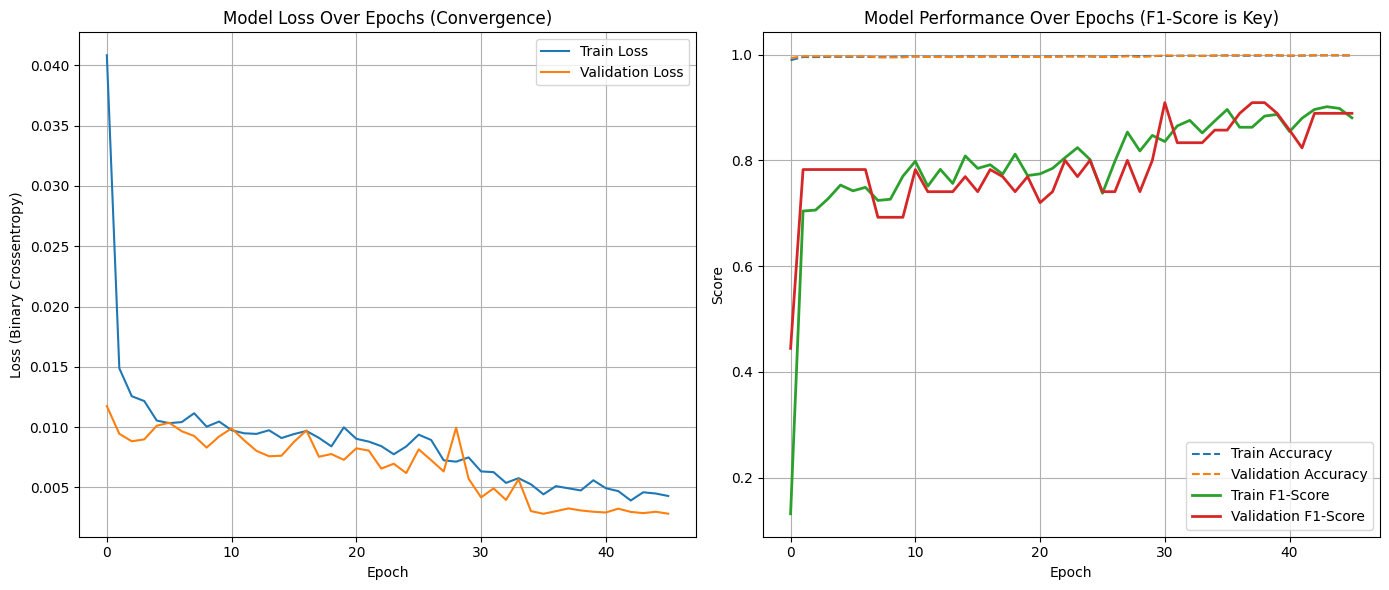

In [5]:
# ==============================================================================
# SECTION 6: VISUALIZATION (Plot Training History)
# ==============================================================================
import matplotlib.pyplot as plt # <--- THE FIX IS HERE
import numpy as np

# NOTE: This assumes 'history' variable from Section 4 is still in memory.
# If you closed your notebook, you must re-run the training section (Section 4) 
# to recreate the 'history' variable before running this cell!

try:
    plt.figure(figsize=(14, 6))

    # --- Plot 1: Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs (Convergence)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Binary Crossentropy)')
    plt.legend()
    plt.grid(True)

    # --- Plot 2: Accuracy/F1-Metrics ---
    
    # Custom function to calculate F1 from P & R in history
    # The array operations need to handle potential division by zero if P+R=0
    
    # Calculate Training F1-Score
    precision_train = np.array(history.history['precision'])
    recall_train = np.array(history.history['recall'])
    f1_train = np.divide(2 * precision_train * recall_train, 
                         precision_train + recall_train, 
                         out=np.zeros_like(precision_train), 
                         where=(precision_train + recall_train) != 0)

    # Calculate Validation F1-Score
    precision_val = np.array(history.history['val_precision'])
    recall_val = np.array(history.history['val_recall'])
    f1_val = np.divide(2 * precision_val * recall_val, 
                       precision_val + recall_val, 
                       out=np.zeros_like(precision_val), 
                       where=(precision_val + recall_val) != 0)


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='--')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
    plt.plot(f1_train, label='Train F1-Score', linewidth=2)
    plt.plot(f1_val, label='Validation F1-Score', linewidth=2)
    
    plt.title('Model Performance Over Epochs (F1-Score is Key)')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

except NameError:
    print("FATAL ERROR: 'history' variable not found. You must run the training cell (Section 4) first!")
except Exception as e:
    print(f"An unexpected error occurred during plotting: {e}")

In [6]:
# ==============================================================================
# SECTION 7: SINGLE-SAMPLE PREDICTION CHECK
# ==============================================================================
# Use one sample from the test set
sample_index = 0 
sample_X = X_test[sample_index].reshape(1, X_test.shape[1], X_test.shape[2])
sample_Y_true = y_test[sample_index]

# Predict the sample
prediction_proba = model.predict(sample_X)[0][0]
prediction_class = int(prediction_proba > 0.5)

print(f"--- Single Sample Prediction Check (Index {sample_index}) ---")
print(f"Actual Label (0=Normal, 1=Fault): {sample_Y_true}")
print(f"Predicted Probability of Fault (1): {prediction_proba:.4f}")
print(f"Predicted Class: {prediction_class}")

if prediction_class == sample_Y_true:
    print("Result: Correctly classified!")
else:
    print("Result: Misclassified. Analyze this sample for robustness.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
--- Single Sample Prediction Check (Index 0) ---
Actual Label (0=Normal, 1=Fault): 0
Predicted Probability of Fault (1): 0.0000
Predicted Class: 0
Result: Correctly classified!
